In [322]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import tensorflow
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Input
import itertools
from keras.losses import binary_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier

### Importing the Dataset

In [211]:
###Importing the dataset

df=pd.read_csv("energydata_complete.csv")

In [212]:
### Splitting classes based on its Median

df['Appliances_class'] = [0 if x <= 60 else 1 for x in df['Appliances']] 
# df_logistic = df.drop(columns = ['Appliances'])

In [213]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'Appliances_class'],
      dtype='object')

In [214]:
df['Appliances_class'].value_counts()

0    10744
1     8991
Name: Appliances_class, dtype: int64

In [215]:
pd.DataFrame(df['lights'].value_counts()).T

,0,10,20,30,40,50,60,70
lights,15252,2212,1624,559,77,9,1,1


### Feature 'lights' can be removed as it has most of the data points to be 0

In [216]:
df.drop(columns=['Appliances','lights','date'],inplace=True)

In [218]:
corr=df.corr()
print("Features with high correlation >0.85\n")
print("Feature1\tFeature2\tCorrelation")

for i in range(len(corr.columns)):
    for j in range(i):
        if(corr.iloc[i,j]>0.85):
            print(corr.columns[i],"\t\t",corr.columns[j],"\t\t", round(corr.iloc[i,j],3))
 

Features with high correlation >0.85

Feature1	Feature2	Correlation
T3 		 T1 		 0.892
T4 		 T1 		 0.877
T4 		 T3 		 0.853
RH_4 		 RH_1 		 0.88
RH_4 		 RH_3 		 0.899
T5 		 T1 		 0.885
T5 		 T3 		 0.888
T5 		 T4 		 0.872
T7 		 T4 		 0.878
T7 		 T5 		 0.871
RH_7 		 RH_4 		 0.894
T8 		 T7 		 0.882
RH_8 		 RH_7 		 0.884
T9 		 T3 		 0.901
T9 		 T4 		 0.889
T9 		 T5 		 0.911
T9 		 T7 		 0.945
T9 		 T8 		 0.869
RH_9 		 RH_4 		 0.857
RH_9 		 RH_7 		 0.859
RH_9 		 RH_8 		 0.856
T_out 		 T6 		 0.975
rv2 		 rv1 		 1.0


In [219]:
# T3, RH_4, T5, T8, RH_7, T7, RH_8, T6, rv2           
df.drop(columns=['T3','RH_4','T5','T8','RH_7','T7','RH_8','T6','rv2','Visibility','rv1'],inplace=True)

In [220]:
df.shape

(19735, 16)

### Getting the count of outliers from each column

In [221]:
q1= df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3-q1   ###Inter-Quartile Range

upper_threshold = q3 + (1.5 * IQR)
lower_threshold = q1 - (1.5 * IQR)

outliers = dict()
column = 0
for upper,lower in zip(upper_threshold,lower_threshold):
    outliers_count = df[df.iloc[:,column]>math.ceil(upper)].shape[0] + df[df.iloc[:,column]<math.floor(lower)].shape[0]
    outliers[df.columns[column]] = outliers_count
    column = column + 1

In [222]:
outliers

{'T1': 283,
 'RH_1': 119,
 'T2': 424,
 'RH_2': 180,
 'RH_3': 4,
 'T4': 32,
 'RH_5': 1258,
 'RH_6': 0,
 'T9': 0,
 'RH_9': 0,
 'T_out': 382,
 'Press_mm_hg': 177,
 'RH_out': 226,
 'Windspeed': 124,
 'Tdewpoint': 0,
 'Appliances_class': 0}

In [223]:
df = df[(df["RH_5"] > 33.005) & (df["RH_5"] < 66.058333)]

### Feature Scaling

In [224]:
def feature_scaling(df_unscaled):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_unscaled)
    scaled_data = pd.DataFrame(scaled_data, columns = df_unscaled.columns)
    return(scaled_data)

### Train-Test Split

In [225]:
x=df.loc[:, df.columns != 'Appliances_class']
x=feature_scaling(x)
y=df['Appliances_class']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)


### Experimenting with combination of neurons and layers

In [332]:
initial_neurons = [7, 10, 15]
layers_list = [2,3]
layer_neurons_df =pd.DataFrame()
acc_list = []
for layer_no in layers_list:
    neurons_combinations = [p for p in itertools.product(initial_neurons, repeat=layer_no)]
    for neurons in neurons_combinations:
        model = Sequential()
        for layer in range(1,layer_no+1):
            if (layer == 1):
                model.add(Dense(neurons[0], input_dim=15, activation='sigmoid'))
            else:
                model.add(Dense(neurons[layer-1],activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))
        optimizer_value = keras.optimizers.Adam(learning_rate=0.005)
        model.compile(optimizer=optimizer_value, loss='binary_crossentropy', metrics=['acc'])
        model.fit(X_train, y_train, batch_size = 200,epochs=100,verbose=0)
        pred = model.predict_classes(X_test)
        acc = accuracy_score(y_test,pred)
        values = [acc,layer_no,neurons]
        values = pd.DataFrame(values).T
        layer_neurons_df = pd.concat([layer_neurons_df,values])

layer_neurons_df.columns = ['Accuracy','Layer','Neurons']
top10 = layer_neurons_df.sort_values(by=['Accuracy'],ascending=False).head(10)

### Plot for Accuracy Vs (Neurons and Layers)

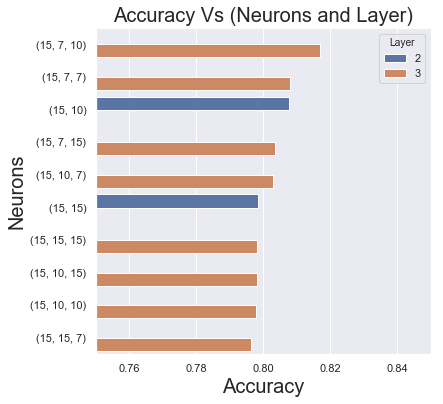

In [238]:
plt.figure(figsize=(6,6))
flatui = ["#9b59b6", "#3498db", "#95a5a6"]
sns.barplot(data=top10 ,x='Accuracy', y='Neurons',hue='Layer').set(xlim=(0.75, 0.85))
plt.title("Accuracy Vs (Neurons and Layer)",fontsize=20)
plt.xlabel("Accuracy",fontsize=20)
plt.ylabel("Neurons",fontsize=20)
plt.show()

### Experimenting with Epochs

In [324]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

epoch_list = [5,10,20,50,100,150,200,300,350,400]
y_train = pd.DataFrame(y_train)
epoch_df_validation = pd.DataFrame()
epoch_df_train = pd.DataFrame()

for epoch in epoch_list:
    scores_validation = []
    scores_train = []
    for train, test in kfold.split(X_train, y_train):
        train = train.tolist()
        test = test.tolist()
        
        model = Sequential()  ###Creating the model
        model.add(Dense(15, input_dim=15, activation='sigmoid'))    ###Adding layers
        model.add(Dense(7, activation='sigmoid'))
        model.add(Dense(10, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))
        optimizer_value = keras.optimizers.Adam(learning_rate=0.01)
        model.compile(loss='binary_crossentropy', optimizer=optimizer_value, metrics=['accuracy'])
        
        # Fitting the model and getting the training scores
        model.fit(X_train.iloc[train,:], y_train.iloc[train,:], batch_size=200,epochs=epoch, verbose=0)
        train_scores = model.evaluate(X_train.iloc[train,:], y_train.iloc[train,:], verbose=0)
        scores_train.append(train_scores[1])
        # Evaluating the model
        validation_scores = model.evaluate(X_train.iloc[test,:], y_train.iloc[test,:], verbose=0)
        scores_validation.append(validation_scores[1])
    
    print(epoch,np.mean(scores_train),np.mean(scores_validation))
    
    validation_values = [epoch,np.mean(scores_validation)]
    validation_values = pd.DataFrame(validation_values).T
    epoch_df_validation = pd.concat([epoch_df_validation,validation_values])
    
    
    train_values = [epoch,np.mean(scores_train)]
    train_values = pd.DataFrame(train_values).T
    epoch_df_train = pd.concat([epoch_df_train,train_values])
    

epoch_df_validation.columns = ['Epoch','Accuracy']
epoch_df_train.columns = ['Epoch','Accuracy']

5 0.7282854914665222 0.727005124092102
10 0.74526526927948 0.7381827712059021
20 0.7757904767990113 0.76946120262146
50 0.8144453167915344 0.7991141676902771
100 0.8306488275527955 0.8113021373748779
150 0.8408175110816956 0.8199170351028442
200 0.8404293298721314 0.8166563510894775
300 0.8555847883224488 0.8297762989997863
350 0.853256368637085 0.8313275337219238
400 0.8581857681274414 0.8301613330841064


### Plots for Accuracy Scores Vs Epoch

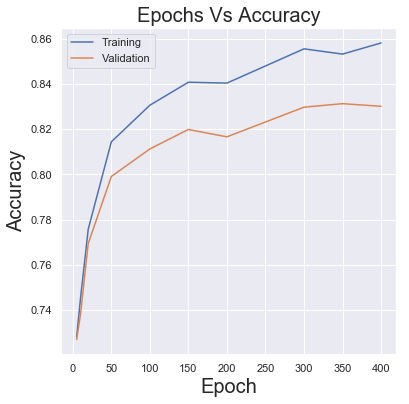

In [325]:
plt.figure(figsize=(6,6))
plt.plot(epoch_df_train['Epoch'],epoch_df_train['Accuracy'])
plt.plot(epoch_df_validation['Epoch'],epoch_df_validation['Accuracy'])
plt.title("Epochs Vs Accuracy",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.legend(['Training','Validation'])
plt.show()

### Experimenting with number of hidden layers

In [241]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
layers_list = [1,2,3,4,5]  ###Hidden Layers
y_train = pd.DataFrame(y_train)
df_layers_train = pd.DataFrame()
df_layers_validation = pd.DataFrame()

for layer in layers_list:
    model = Sequential()
    scores_validation = []
    scores_train = []
    for tmp in range(layer):
        if tmp == 0:
            model.add(Dense(15, input_dim=15,activation='sigmoid'))
        elif tmp == 1:
            model.add(Dense(7, activation='sigmoid'))
        elif tmp == 2:
            model.add(Dense(10, activation='sigmoid'))
        else:
            model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    for train, test in kfold.split(X_train, y_train):
        train = train.tolist()
        test = test.tolist()
        optimizer_value = keras.optimizers.Adam(learning_rate=0.01)
        model.compile(loss='binary_crossentropy', optimizer=optimizer_value, metrics=['accuracy'])
        # Fit the model
        model.fit(X_train.iloc[train,:], y_train.iloc[train,:],batch_size = 200,epochs=300, verbose=0)
        # Getting the Training scores
        train_scores = model.evaluate(X_train.iloc[train,:], y_train.iloc[train,:], verbose=0)
        scores_train.append(train_scores[1])
        # Evaluating the model
        validation_scores = model.evaluate(X_train.iloc[test,:], y_train.iloc[test,:], verbose=0)
        scores_validation.append(validation_scores[1])
    
    print(layer,np.mean(scores_train),np.mean(scores_validation))
    
    validation_values = [layer,np.mean(scores_validation)]
    validation_values = pd.DataFrame(validation_values).T
    df_layers_validation = pd.concat([df_layers_validation,validation_values])
    
    
    train_values = [layer,np.mean(scores_train)]
    train_values = pd.DataFrame(train_values).T
    df_layers_train = pd.concat([df_layers_train,train_values])
    

df_layers_train.columns = ['Layer','Accuracy']
df_layers_validation.columns = ['Layer','Accuracy']
    

1 0.8337342977523804 0.8174339532852173
2 0.8519559264183044 0.8349766850471496
3 0.866684353351593 0.8399451971054077
4 0.8728554010391235 0.8494155764579773
5 0.8614840269088745 0.8418859958648681


### Plots for Scores Vs Layers

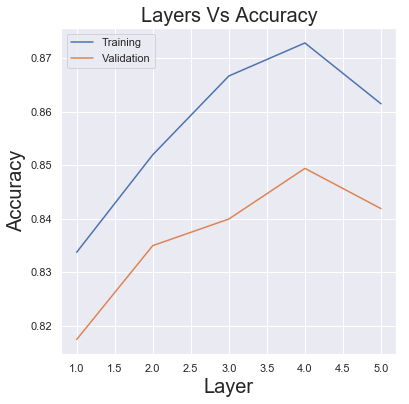

In [242]:
plt.figure(figsize=(6,6))
plt.plot(df_layers_train['Layer'],df_layers_train['Accuracy'])
plt.plot(df_layers_validation['Layer'],df_layers_validation['Accuracy'])
plt.title("Layers Vs Accuracy",fontsize=20)
plt.xlabel("Layer",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.legend(['Training','Validation'])
plt.show()

### Experimenting with Activation

In [262]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_train = pd.DataFrame(y_train)
df_activation_train = pd.DataFrame()
df_activation_validation = pd.DataFrame()
activation_list = ['sigmoid','relu','tanh']

for count in range(len(activation_list)):
    scores_train = []
    scores_validation = []
    model = Sequential()
    model.add(Dense(15, input_dim=15, activation=activation_list[count]))
    model.add(Dense(7, activation=activation_list[count]))
    model.add(Dense(10, activation=activation_list[count]))
    model.add(Dense(1, activation='sigmoid'))
    for train, test in kfold.split(X_train, y_train):
        train = train.tolist()
        test = test.tolist()
        
        optimizer_value = keras.optimizers.Adam(learning_rate=0.01)
        model.compile(loss='binary_crossentropy', optimizer=optimizer_value, metrics=['accuracy'])
        # Fit the model
        model.fit(X_train.iloc[train,:], y_train.iloc[train,:],batch_size = 200,epochs=300, verbose=0)
        # evaluate the model
        train_scores = model.evaluate(X_train.iloc[train,:], y_train.iloc[train,:], verbose=0)
        scores_train.append(train_scores[1])
        # Evaluating the model
        validation_scores = model.evaluate(X_train.iloc[test,:], y_train.iloc[test,:], verbose=0)
        scores_validation.append(validation_scores[1])
    
    print(activation_list[count],np.mean(scores_train),np.mean(scores_validation))
    
    validation_values = [activation_list[count],np.mean(scores_validation)]
    validation_values = pd.DataFrame(validation_values).T
    df_activation_validation = pd.concat([df_activation_validation,validation_values])
    
    
    train_values = [activation_list[count],np.mean(scores_train)]
    train_values = pd.DataFrame(train_values).T
    df_activation_train = pd.concat([df_activation_train,train_values])
    

df_activation_train.columns = ['Activation','Training Accuracy']
df_activation_validation.columns = ['Activation','Test Accuracy']

sigmoid 0.867130720615387 0.8404098868370056
relu 0.8481913447380066 0.8281457781791687
tanh 0.8649771451950073 0.8361414313316345


In [265]:
df_activation_train.columns = ['Activation','Training Accuracy']
df_activation_validation.columns = ['Activation','Test Accuracy']
df_merged = pd.merge(df_activation_train,df_activation_validation,how='inner',on='Activation')
df_merged = df_merged.set_index('Activation') 

### Plot for Accuracy Vs Activation Fuctions

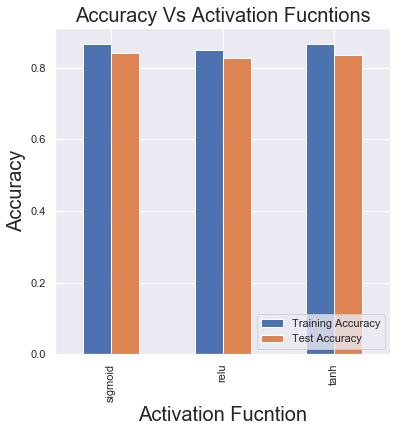

In [290]:
df_merged.plot.bar(figsize=(6,6))
plt.legend(loc="lower right")
plt.title("Accuracy Vs Activation Fucntions",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.xlabel("Activation Fucntion",fontsize=20)
plt.show()

### Model Implementation with the Best Parameters

In [297]:
model = Sequential()
model.add(Dense(15, input_dim=15, activation='sigmoid'))
model.add(Dense(7, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
optimizer_value = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer_value, metrics=['accuracy'])

model.fit(X_train, y_train,batch_size = 200,epochs=300, verbose=0)
train_scores = model.evaluate(X_train, y_train, verbose=0)
training_accuracy = train_scores[1]

test_scores = model.evaluate(X_test, y_test, verbose=0)
test_accuracy = test_scores[1]

In [311]:
print("Training Accuracy is: ", training_accuracy)
print("Training Accuracy is: ", test_accuracy)

Training Accuracy is:  0.8722347021102905
Training Accuracy is:  0.8388265371322632


In [312]:
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
Actual 0,2592,461
Actual 1,429,2040


In [313]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.86      0.85      0.85      3053
          1       0.82      0.83      0.82      2469

avg / total       0.84      0.84      0.84      5522



## K Nearest Neighbors

In [330]:
x=df.loc[:, df.columns != 'Appliances_class']
x=feature_scaling(x)
y=df['Appliances_class']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)


### Hyperparameter tuning to find the Number of Neighbors

In [253]:
from sklearn.model_selection import cross_val_score

score_list = []
for neighbor in range(1,100):
    model = KNeighborsClassifier(n_neighbors=neighbor)
    scores = cross_val_score(model, X_train, y_train, cv=3)
#     print(neighbor, scores.mean())
    score_list.append(scores.mean())
    
neighbor_accuracy_df = pd.DataFrame({'Accuracy':score_list}) 

### Plot for Number of Neighbors and Accuracy

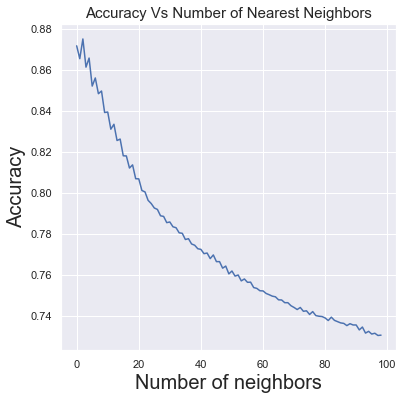

In [256]:
plt.figure(figsize=(6,6))
plt.plot(neighbor_accuracy_df)
plt.title("Accuracy Vs Number of Nearest Neighbors",fontsize=15)
plt.xlabel("Number of neighbors",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.show()

### Hyperparameter Tuning to find the Best Distance Metric

In [201]:
from sklearn.model_selection import cross_val_score

# neighbors = [1,2,3,4,5,6,7,8]
distance_neighbor_df = pd.DataFrame()
distance_metrics_list = ['chebyshev','minkowski','manhattan']
for distance_metric in distance_metrics_list:
    for neighbor in range(1,11):
        model = KNeighborsClassifier(n_neighbors=neighbor,metric = distance_metric)
        scores = cross_val_score(model, X_train, y_train, cv=3)
#     print(neighbor, scores.mean())                          
        values  =  [distance_metric,neighbor,scores.mean()]
        values = pd.DataFrame(values).T
        distance_neighbor_df = pd.concat([distance_neighbor_df,values])

distance_neighbor_df.columns = ['Distance Metric','Neighbor','Accuracy']
distance_neighbor_df['Neighbor'] = distance_neighbor_df['Neighbor'].astype(float)
distance_neighbor_df['Accuracy'] = distance_neighbor_df['Accuracy'].astype(float)

### Accuracy Vs (Distance Metric and Neighbors)

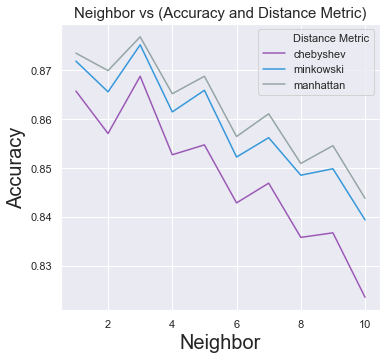

In [207]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6"]
sns.set(rc={'figure.figsize':(5.7,5.27)})
sns.lineplot(data=distance_neighbor_df, x='Neighbor', y='Accuracy',hue='Distance Metric',palette=flatui)
plt.xlabel("Neighbor",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.title("Neighbor vs (Accuracy and Distance Metric)",fontsize=15)
plt.show()

### Learning Curve with Train Size Vs Accuracy

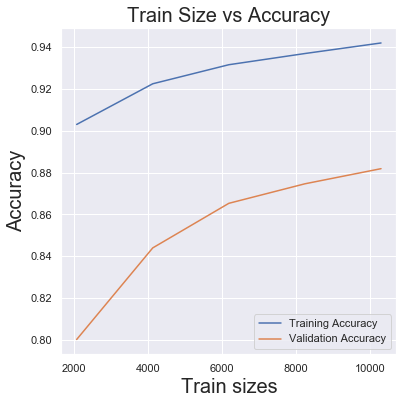

In [331]:
train_sizes, train_scores, valid_scores = learning_curve(KNeighborsClassifier(n_neighbors=3,metric = 'manhattan'), 
    X_train, y_train,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,random_state=1,shuffle=True)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(6,6))
plt.plot(train_sizes, train_mean, label = 'Training Accuracy')
plt.plot(train_sizes, valid_mean, label = 'Validation Accuracy')
plt.xlabel("Train sizes",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.title("Train Size vs Accuracy",fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Fitting the Model with the Best Parameters

In [319]:
model = KNeighborsClassifier(n_neighbors=3,metric = 'manhattan')
model.fit(X_train,y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print("Training Accuracy:", accuracy_score(y_train,pred_train))
print("Test Accuracy:", accuracy_score(y_test,pred_test))

Training Accuracy: 0.9457424512924009
Test Accuracy: 0.888627308946034


In [320]:
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
Actual 0,2793,260
Actual 1,355,2114


In [321]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.89      0.91      0.90      3053
          1       0.89      0.86      0.87      2469

avg / total       0.89      0.89      0.89      5522

